In [7]:
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

import seaborn as sns
sns.set_theme(style="whitegrid")

# Loading the dataset
- data is loaded from `sklearn` and classes are filtered to keep only two classes (3 and 8)
- the data is then split into train, validation, and test sets
- the labels are converted to -1 and 1 to be used in the LR model

In [8]:
# load a dataset
digits = load_digits()
# filter data to only include two classes
class1, class2 = 1, 0
idxs = (digits.target == class1) | (digits.target == class2)
data_x, data_y = digits.data[idxs], digits.target[idxs]
print(data_x.shape)
# change labels to -1 and +1
data_y[data_y==class1] = -1
data_y[data_y==class2] = 1
# split the data into training, validation, and test sets
x_train, x_test, y_train, y_test = train_test_split(data_x, data_y, test_size=0.2, stratify=data_y)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25, stratify=y_train)
print(x_train.shape, x_val.shape, x_test.shape)

(360, 64)
(216, 64) (72, 64) (72, 64)


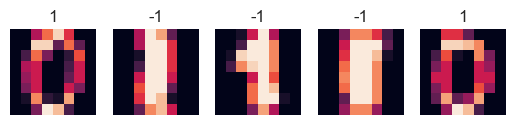

In [9]:
# visualize a number of images from the dataset
idxs = [random.choice(range(x_train.shape[0])) for _ in range(5)]
fig, ax = plt.subplots(1, 5)
for i, idx in enumerate(idxs):
    ax[i].imshow(x_train[idx].reshape(8, 8))
    ax[i].axis('off')
    # add label to the image
    ax[i].set_title(y_train[idx])
plt.show()

# Defining the Logistic Regression model

In [10]:
class LogisticRegression:
    '''
    A simple logistic regression model.  This class assumes all labels 
    are either -1 or 1.
    '''
    def __init__(self, learning_rate=0.01, max_iters=10, log_every=1):
        '''
        Initializes the model with learning rate and maximum iterations.
        Args:
            learning_rate: The learning rate for gradient descent.
            max_iters: The maximum number of iterations for training.
            log_every: Log the loss every `log_every` iterations.
        '''
        self.learning_rate = learning_rate
        self.max_iters = max_iters
        self.log_every = log_every
        self.weights = None

    def __sigmoid(self, z):
        '''
        Calculates the sigmoid function.
        Args:
            z: A NumPy array of input values.
        Returns:
            A NumPy array of sigmoid values.
        '''
        return 1 / (1 + np.exp(-z))
    
    def __loss(self, X, y):
        '''
        Calculates the cost function (binary cross-entropy).
        Args:
            X: A NumPy array of feature vectors.
            y: A NumPy array of target labels.
        Returns:
            The cross-entropy loss (scalar) and the gradient of the 
            loss with respect to weights (ndarray).
        '''
        # calculate a temporary value needed by both loss and gradient
        inv = -y * (X @ self.weights)
        loss = np.log(1 + np.exp(inv)).mean()
        dw = self.__sigmoid(inv) * -y * X
        dw = np.mean(dw, axis=0, keepdims=True).T
        return loss, dw
    
    def __forward(self, X):
        '''
        Predicts the probabilities for new data.
        Args:
            X: A NumPy array of feature vectors.
        Returns:
            A NumPy array of predicted probabilities.
        '''
        z = X @ self.weights
        y_pred = self.__sigmoid(z)
        return y_pred
    
    def __preprocess(self, X, y):
        '''
        Adds a "bias" column to the feature vectors and reshapes
        the target labels to be a column vector.
        Args:
            X: A NumPy array of feature vectors.
            y: A NumPy array of target labels.
        Returns:
            The preprocessed feature vectors and target labels.
        '''
        newX = np.hstack((np.ones((X.shape[0],1)), X))
        newY = y.reshape(-1, 1)
        return newX, newY

    def train(self, X, y, x_val, y_val):
        '''
        Trains the model using full batch gradient descent.
        Note that this method does initialize the weights.
        Args:
            X: A NumPy array of feature vectors.
            y: A NumPy array of target labels.
            x_val: A NumPy array of feature vectors for validation.
            y_val: A NumPy array of target labels for validation.
        '''
        history = np.zeros((self.max_iters//self.log_every, 3))
        newX, newY = self.__preprocess(X, y)
        newX_val, newY_val = self.__preprocess(x_val, y_val)
        # initialize weights and bias with random values
        self.weights = np.random.rand(newX.shape[1], 1)
        for i in range(self.max_iters):
            # calculate gradients
            loss, dw = self.__loss(newX, newY)
            if (i+1) % self.log_every == 0:
                val_loss, _ = self.__loss(newX_val, newY_val)
                history[i//self.log_every] = (i+1, loss, val_loss)
            # gradient descent step
            self.weights -= (self.learning_rate * dw)
        return history

    def evaluate(self, X, y):
        '''
        Evaluates the model performance using CM and accuracy.
        Args:
            X: A NumPy array of feature vectors.
            y: A NumPy array of target labels.
        Returns:
            The confusion matrix and accuracy.
        '''
        newX, newY = self.__preprocess(X, y)
        y_pred = self.__forward(newX)
        y_pred[y_pred <= 0.5] = -1
        y_pred[y_pred > 0.5] = 1
        cm = confusion_matrix(newY, y_pred)
        acc = accuracy_score(newY, y_pred)
        
        return cm, acc


# Training the model and plotting the loss

<Axes: >

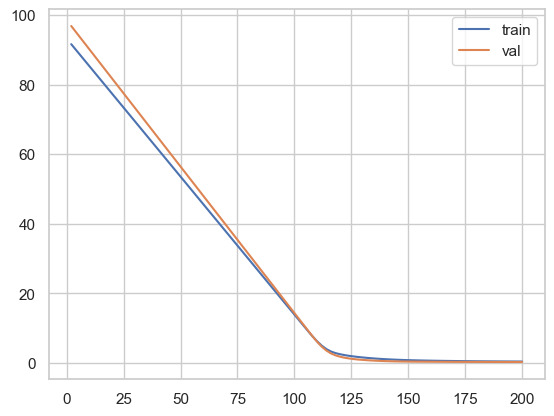

In [11]:
model = LogisticRegression(learning_rate=0.001, max_iters=200, log_every=2)
history = model.train(x_train, y_train, x_val, y_val)
sns.lineplot(x=history[:,0], y=history[:,1], label='train')
sns.lineplot(x=history[:,0], y=history[:,2], label='val')


# Evaluating the model on test set

In [12]:
model.evaluate(x_test, y_test)

(array([[31,  5],
        [ 3, 33]]),
 0.8888888888888888)